# Model Diagnostics

The purpose of this assigment is introduce you to a new library for linear regression called statmodels which is much better suited for inferential modeling than sklearn. This assignment is also to familiarize yourself with some of most important procedures for improving the interpretability of regression coefficients. You will also perform important statistical tests that will help establish that whether or not important assumptions that safeguard the interpretability of OLS coefficients have been met. 

We will continue to use the Ames Housing Dataset so that you can focus on the techniques and not on cleaning/getting associated with a brand new dataset.

## 1.1 Choose an X and Y variable from your dataset and use them to create a Seaborn Regplot

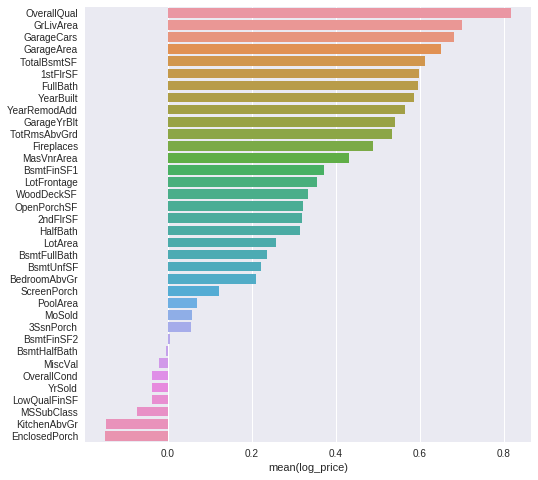

'28 columns'

In [19]:
#!pip install seaborn --upgrade

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

pd.set_option('chop_threshold', 0.001)
pd.set_option('precision',4)

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv")
df.head()

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv")
df['log_price'] = np.log(df['SalePrice'])
df = df.drop(['SalePrice', 'Id'], axis=1)
#df = df[['log_price','OverallQual', 'GrLivArea','GarageCars', 'GarageArea','TotalBsmtSF',]]

# Create a correlation matrix and then sort and compare.
correlation_matrix = df.corr()
corr_rank = correlation_matrix.sort_values('log_price', ascending=False)
plt.figure(figsize=(8,8))        
ax = sns.barplot(corr_rank.log_price[1:], corr_rank.index[1:], orient='h')
plt.show()
#print(corr_rank.log_price[1:])

# Get a sorted list of postively corrilated variables. 
corr = pd.DataFrame(corr_rank.log_price[1:])
corr = corr[corr.log_price > 0.0].T
corr_list = corr.columns.values.tolist()
(f"{len(corr_list)} features")

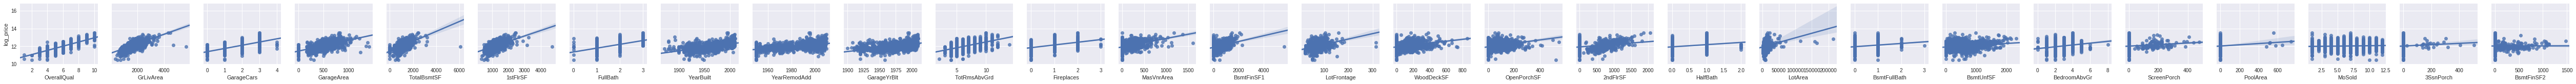

In [21]:
 # plot some Reg plots to check all these out! 
  g = sns.pairplot(data=df, y_vars=['log_price'], x_vars=corr_list, kind="reg")

## 1.2 Now using the X variables that you feel like will be the best predictors of y use statsmodel to run the multiple regression between these variables and Y. You don't need to use every X variable in your dataset, in fact it's probably better if you don't. Just pick ones that you have already cleaned that seem the most relevant to house prices.

In [0]:
# Get a sorted list of postively corrilated variables. 
corr = pd.DataFrame(corr_rank.log_price[1:])
corr = corr[corr.log_price > 0.0].T
corr = corr.drop(["SalePrice"], axis=1)
corr_list = corr.columns.values.tolist()
len(corr_list)

## 1.3 Identify the standard errors and P-Values of these coefficients in the output table. What is the interpretation of the P-values here?

In [0]:
##### Your Code Here #####

## 1.4 Remove outliers from your dataset and run the regression again. Do you see a change in some coefficients? Which seem to move the most?

In [0]:
##### Your Code Here #####

## 1.5 Create a new log(y) variable and use it to run a log-linear regression of your variables using statmodels 

In [0]:
##### Your Code Here #####

## 2.1 Run a test for high levels of collinearity in your dataset. Calculate the Variance Inflation Factor for each X variable. Do you see VIF values greater than ten? If so try omitting those X variables and run your regression again. Do the standard errors change? Do the coefficients change? Do the coefficients seem to have an interpretation that matches your intuition?

In [0]:
##### Your Code Here #####

## 2.2 Variables that have high levels of multicollinearity should also be highly correlated with each other. Calculate your X matrix's correlation matrix to check if the variables highlighted by the VIF test truly are highly correlated.

In [0]:
##### Your Code Here #####

## 2.3 If you have varaibles with high Variance Inflation Factors, try excluding them from your regression. Do your standard errors improve? (get smaller). If high levels of multicollinearity are removed, the precision of the dataset should increase.

In [0]:
##### Your Code Here #####

## 2.4 Recalculate your regression using Robust Standard Errors? What happens to your standard errors?

In [0]:
##### Your Code Here #####

## 2.5 Use scatterplots or Seaborn's pairplot functionality to perform an eyeball test for potential variables that would be candidates for generating polynomial regressors. 

In [0]:
##### Your Code Here #####

## 2.6 Use seaborn's residplot to plot the distribution of each x variable's residuals. Does these plots indicate any other features that would be potential candidates for polynomial features.

In [0]:
##### Your Code Here #####

## 2.6 Feature Engineer the appropriate polynomial features from your analysis above and include them in one final log-polynomial, robust standard error, regression. Do the coefficients of this most advanced regression match your intuition better than the coefficients of the very first regression that we ran with the Statmodels library?

In [0]:
##### Your Code Here #####